# Used Car Price Prediction

### Introduction


The primary goal of this competition is to achieve a low **Root Mean Squared Error (RMSE)**, the evaluation metric for this hackathon.


### Dataset Overview

The competition provides two main files:

* **`train.csv`**: The training dataset, which includes the `price` column which is the target variable.
* **`test.csv`**: The test dataset, which does not include `price` , and we have to predict the price for each car.


### Metadata

`Brand & Model` : Identify the brand or company name along with the specific model of each vehicle.

`Model Year` : Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.

`Mileage` : Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.

`Fuel Type` : Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.

`Engine Type` : Understand the engine specifications, shedding light on performance and efficiency.

`Transmission` : Determine the transmission type, whether automatic, manual, or another variant.

`Exterior & Interior Colors` : Explore the aesthetic aspects of the vehicles, including exterior and interior color options.

`Accident History` : Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.

`Clean Title` : Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.

`Price` : Access the listed prices for each vehicle, aiding in price comparison and budgeting.


### Note: 
This dataset is a valuable resource for automotive enthusiasts, buyers, and researchers interested in analyzing trends, making informed purchasing decisions or conducting studies related to the automotive industry and consumer preferences.

### Import necessary libraries

In [7]:
# === Data Handling & Exploration ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# === Preprocessing & Feature Engineering ===
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
)
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, cross_val_score
)
from sklearn.metrics import mean_squared_error
from dateutil import parser
import nltk

# === Modeling: Traditional ML ===
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# === Gradient Boosting Libraries ===
import xgboost as xgb
#import lightgbm as lgb
#import catboost as cb

# === Ensembling & Stacking ===
from sklearn.ensemble import StackingRegressor, VotingRegressor
#from mlxtend.regressor import StackingCVRegressor

# === Hyperparameter Tuning ===
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# === Utilities ===
from tqdm import tqdm
import joblib
import pickle
import warnings
warnings.filterwarnings("ignore")

###  Loading Dataset


In [9]:
train_df = pd.read_csv(r'C:\Users\user\Downloads\hackathon-qualification\train.csv')
test_df = pd.read_csv(r'C:\Users\user\Downloads\hackathon-qualification\test.csv')

In [9]:
# Load Train Set
train_df.head(4)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000


In [11]:
train_df.shape

(188533, 13)

In [13]:
# Load Test Set
test_df.head(4)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN


In [15]:
test_df.shape

(125690, 12)

In [17]:
# CHecking for null values
test_df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

### Exploratory Data Analysis

In [19]:
# Check basic information about the train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [159]:
train_df.columns

Index(['id', 'milage', 'clean_title', 'price', 'brand_grouped', 'model',
       'car_age', 'car_age_bucket', 'mileage_per_year', 'fuel_type',
       'horsepower', 'engine_size', 'cylinders', 'transmission', 'ext_col',
       'int_col', 'accident'],
      dtype='object')

In [163]:
strings = list(train_df.dtypes[train_df.dtypes == 'object'].index)
strings

['brand_grouped', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col']

In [ ]:
for col in train.columns:
    print(col)
    print(train[col].unique()[:5])
    print(train[col].nunique())
    print()

In [23]:
train_df.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


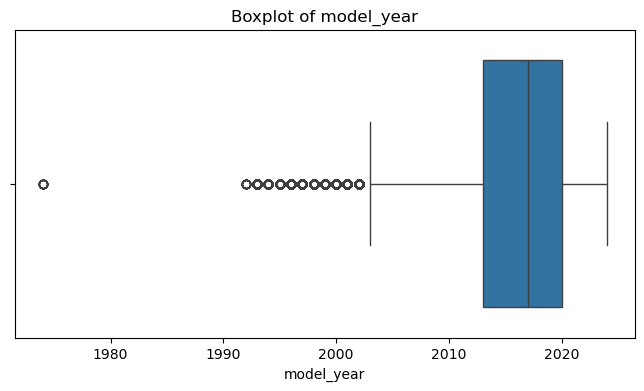

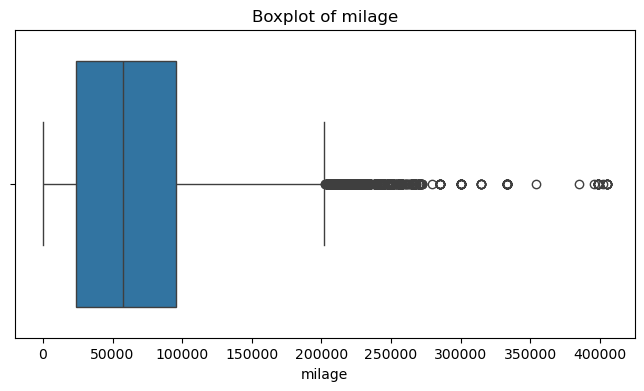

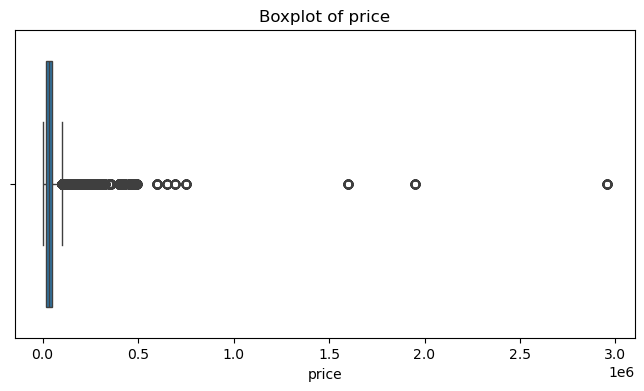

In [17]:
# Check for Outliers
numeric_cols = ['model_year', 'milage', 'price']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [19]:
# Loop through all numeric features and compute distribution + outliers
for feature in numeric_cols:
    print(f"\n### Summary for {feature} ###")

    # Show standard descriptive statistics (count, mean, std, min, quartiles, max)
    print(train_df[feature].describe())

    # Interquartile range (IQR) method for detecting potential outliers
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Extract data points outside the acceptable range
    potential_outliers = train_df.loc[
        (train_df[feature] < lower_limit) | (train_df[feature] > upper_limit),
        feature
    ]

    print(f"Detected outliers: {potential_outliers.shape[0]}")
    print("Example outlier values:", potential_outliers.head(10).tolist())



### Summary for model_year ###
count    188533.000000
mean       2015.829998
std           5.660967
min        1974.000000
25%        2013.000000
50%        2017.000000
75%        2020.000000
max        2024.000000
Name: model_year, dtype: float64
Detected outliers: 5132
Example outlier values: [2002, 2002, 2001, 2000, 2002, 2001, 2001, 2001, 2001, 2002]

### Summary for milage ###
count    188533.000000
mean      65705.295174
std       49798.158076
min         100.000000
25%       24115.000000
50%       57785.000000
75%       95400.000000
max      405000.000000
Name: milage, dtype: float64
Detected outliers: 1766
Example outlier values: [213000, 212500, 244200, 269885, 215000, 209500, 245000, 242000, 212000, 230000]

### Summary for price ###
count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64
Detected outliers: 10880
Example outlier 

In [23]:
# --- Inspect unique values for selected features

selected_columns = [
    "brand", "model", "model_year", "milage", "fuel_type",
    "engine", "transmission", "ext_col", "int_col", "accident",
    "clean_title", "price"
]

for feature in selected_columns:
    uniques = train_df[feature].unique()
    print(f"\n▶ {feature} | {len(uniques)} distinct entries")
    print(uniques)



▶ brand | 57 distinct entries
['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

▶ model | 1897 distinct entries
['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']

▶ model_year | 34 distinct entries
[2007 2002 2017 2021 2018 2016 2020 2015 2011 2013 2023 2019 2012 2014
 2008 2009 2022 2003 2005 2001 2006 2000 2010 2004 1997 1998 1999 1994
 1993 1996 1995 2024 1974 1992]

▶ milage | 6651 distinct entries
[213000 143250 136731 ...   4721   2922

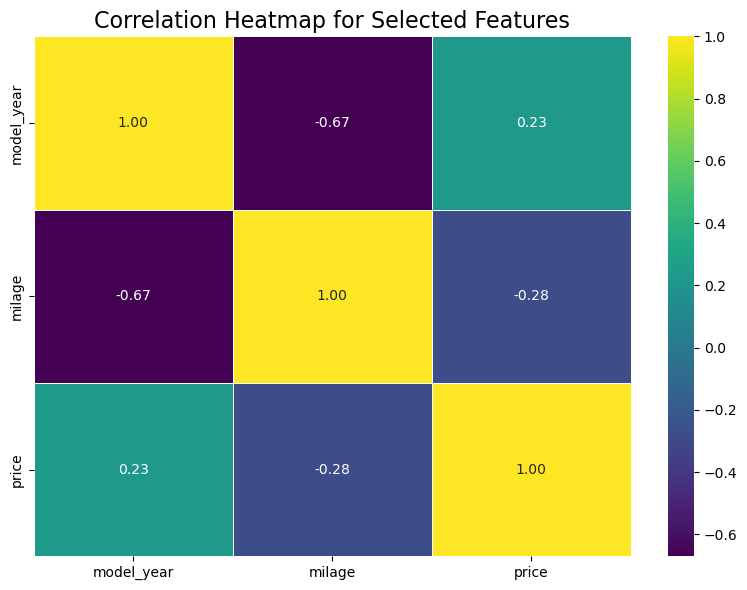

In [69]:
# Select the relevant columns
selected_columns = ['odometer', 'condition', 'car_age_at_sale', 'price']
filtered_corr = train_df[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = filtered_corr.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True,  fmt='.2f', cmap='viridis', linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap for Selected Features', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

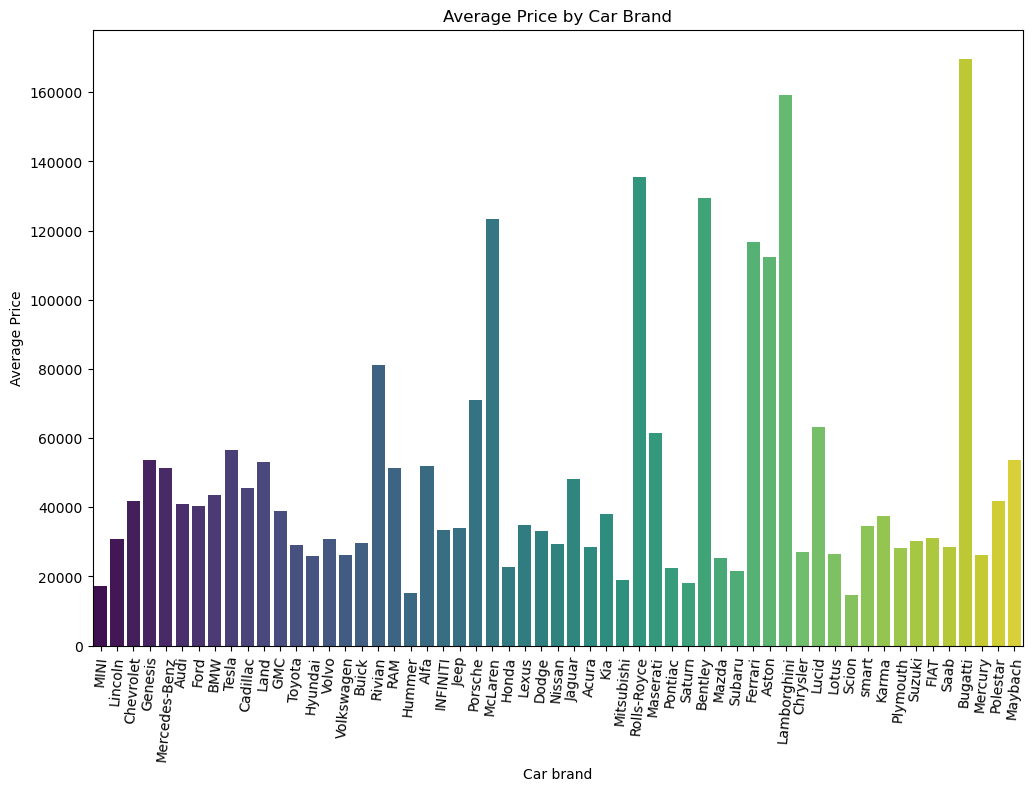

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(x='brand', y='price', data= train_df, errorbar=None, palette='viridis') 
plt.title('Average Price by Car Brand')
plt.xlabel('Car brand')
plt.ylabel('Average Price')
plt.xticks(rotation=85)  
plt.show() 

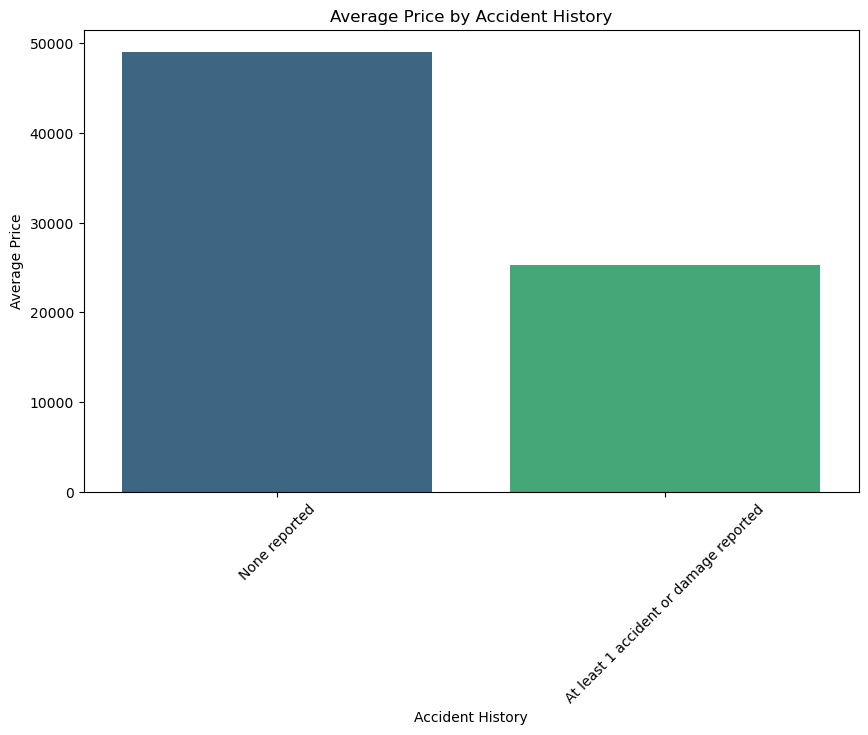

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x='accident', y='price', data= train_df, errorbar=None, palette='viridis') 
plt.title('Average Price by Accident History')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show() 

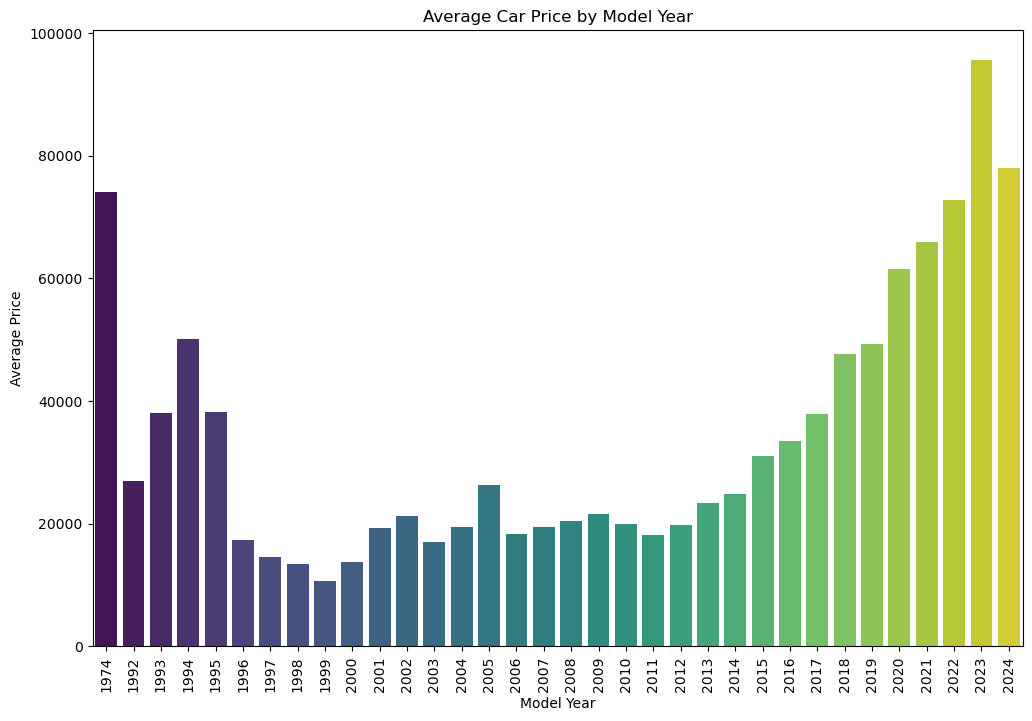

In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(x='model_year', y='price', data= train_df, errorbar= None, palette='viridis')
plt.title('Average Car Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=90)  
plt.show() 

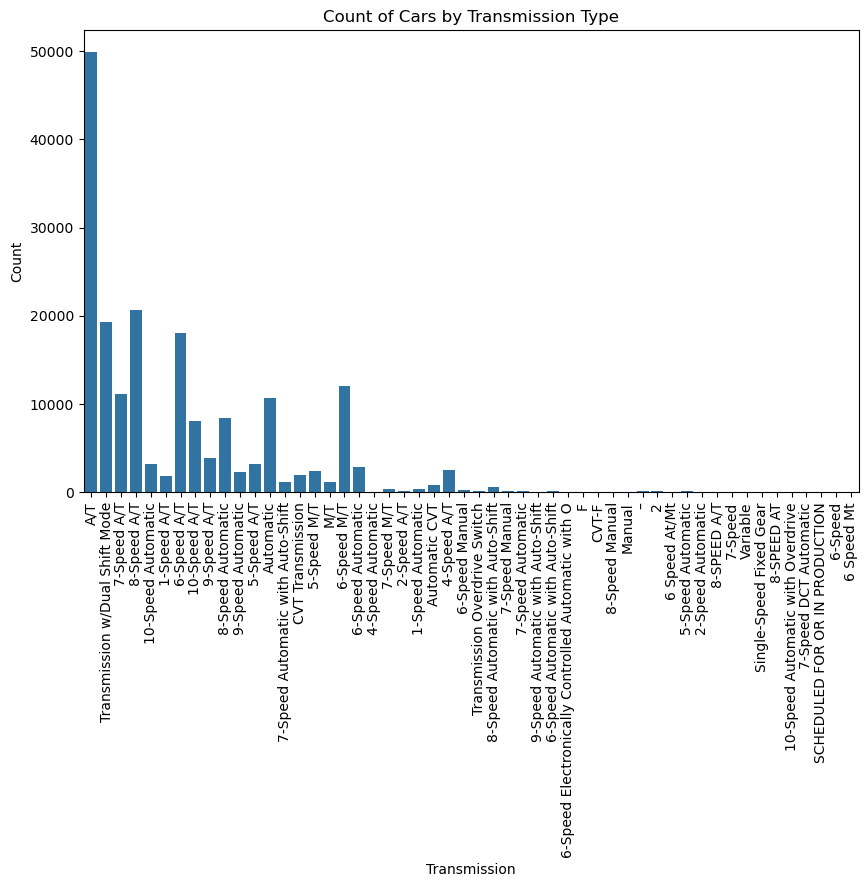

In [67]:
plt.figure(figsize=(10, 6))
sns.countplot(x='transmission', data=  train_df)  
plt.title('Count of Cars by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show() 

## Data Cleaning and Feature Engineering

In [37]:
# Getting the value counts of each brand in the training set
brand_car = train_df['brand'].value_counts()

In [39]:
brand_car

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

In [41]:
# Identifying brands that are uncommon
rare_brands = brand_car[brand_car < len(train_df) * 0.01].index
rare_brands

Index(['Volkswagen', 'Jaguar', 'Bentley', 'MINI', 'Genesis', 'Buick',
       'Maserati', 'Lamborghini', 'Chrysler', 'Volvo', 'Alfa', 'Rivian',
       'Rolls-Royce', 'Mitsubishi', 'Pontiac', 'Hummer', 'Ferrari', 'McLaren',
       'Aston', 'Saturn', 'Scion', 'Lucid', 'Mercury', 'Lotus', 'FIAT', 'Saab',
       'Karma', 'Suzuki', 'Plymouth', 'Bugatti', 'Polestar', 'smart',
       'Maybach'],
      dtype='object', name='brand')

In [43]:
# Group infrequent brands into "Other" and update datasets
def group_brands(value, rare_list):
    """Map brand to 'Other' if it belongs to the rare list."""
    return "Other" if value in rare_list else value

train_df["brand_grouped"] = train_df["brand"].apply(lambda b: group_brands(b, rare_brands))
test_df["brand_grouped"] = test_df["brand"].apply(lambda b: group_brands(b, rare_brands))

# Remove the original brand column to avoid duplication
train_df.drop(columns=["brand"], inplace=True)
test_df.drop(columns=["brand"], inplace=True)


In [44]:
# --- Verify brand grouping results ---
brand_counts = train_df["brand_grouped"].value_counts()
print("✔ Distribution of brands (after grouping):")
print(brand_car)
print(f"\nTotal distinct brand categories remaining: {train_df['brand_grouped'].nunique()}")


New brand counts in the training data after grouping:
brand_grouped
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Other            15256
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Name: count, dtype: int64

Number of unique brands after grouping: 25


In [49]:
# --- Frequency distribution of car models in the training set ---
model_frequencies = train_df["model"].value_counts()
print("Top models by occurrence:\n")
print(model_frequencies.head(20))  # show top 20 for readability


model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
IONIQ Plug-In Hybrid SEL            2
X5 3.0i                             1
X5 xDrive40e                        1
XLR Base                            1
Integra w/A-Spec Tech Package       1
Name: count, Length: 1897, dtype: int64

In [51]:
# --- Group infrequent car models into "Other_Model" ---

# Define threshold: models that appear in <1% of training data
threshold = 0.01 * len(train_df)
infrequent_models = model_frequencies[model_frequencies < threshold].index

def group_models(value, rare_list):
    """Replace rare models with 'Other_Model' label."""
    return "Other_Model" if value in rare_list else value

# Apply transformation to both train and test sets
train_df["model"] = train_df["model"].apply(lambda m: group_models(m, infrequent_models))
test_df["model"] = test_df["model"].apply(lambda m: group_models(m, infrequent_models))

# --- Inspect results ---
print("✔ 'model' column updated with grouped values.\n")
print("Frequency distribution (after grouping):")
print(train_df["model"].value_counts())
print(f"\nDistinct models remaining: {train_df['model'].nunique()}")

The old 'model' column is being dropped and replaced with the new grouped column.

Here are the new unique value counts from the training data:
model
Other_Model    183359
F-150 XLT        2945
M3 Base          2229
Name: count, dtype: int64

We are now seeing 3 unique models after grouping.


In [53]:
test_df

,id,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,brand_grouped,model
0,188533,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,Land,Other_Model
1,188534,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,Land,Other_Model
2,188535,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,Ford,Other_Model
3,188536,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,Audi,Other_Model
4,188537,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,Audi,Other_Model
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,2014,83315,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes,Mercedes-Benz,Other_Model
125686,314219,2019,29336,Gasoline,3.0 Liter Turbo,Automatic,White,Black,None reported,NaN,Audi,Other_Model
125687,314220,2012,77634,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,Audi,Other_Model
125688,314221,2012,112000,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,Audi,Other_Model


Step 3: Creating a 'car_age' feature for both train and test data


In [56]:
# --- Feature Engineering: Car Age ---

REFERENCE_YEAR = 2025  # fixed reference point for consistency across datasets

def calculate_car_age(year, ref_year=REFERENCE_YEAR):
    """Compute age of car given its model year and a reference year."""
    return ref_year - year

# Apply to both training and test sets
train_df["car_age"] = train_df["model_year"].apply(calculate_car_age)
test_df["car_age"] = test_df["model_year"].apply(calculate_car_age)

In [58]:
# creating age buckets to group the data
bins = [-1, 5, 10, float('inf')]
labels = ['0-5_years', '6-10_years', '10+_years']

train_df['car_age_bucket'] = pd.cut(train_df['car_age'], bins=bins, labels=labels)
test_df['car_age_bucket'] = pd.cut(test_df['car_age'], bins=bins, labels=labels)

In [60]:
# dropping the original 'model_year' column
train_df.drop('model_year', axis=1, inplace=True)
test_df.drop('model_year', axis=1, inplace=True)

New 'car_age' and 'car_age_bucket' features are being created.
Sample of the new 'car_age' feature from the training data:
0    18
1    23
2    23
3     8
4     4
Name: car_age, dtype: int64

Value counts of the new 'car_age_bucket' feature from the training data:
car_age_bucket
6-10_years    69702
10+_years     60105
0-5_years     58726
Name: count, dtype: int64


In [63]:
# --- Feature Engineering: Mileage per year of usage ---
# Adding +1 to age ensures brand-new cars don't cause division by zero.

for df in (train_df, test_df):
    df["mileage_per_year"] = df["milage"] / (df["car_age"] + 1)


In [65]:
# --- Handle extreme values in 'milage' using percentile clipping

q01, q99 = train_df["milage"].quantile([0.01, 0.99])

for df in (train_df, test_df):
    df["milage"] = df["milage"].clip(lower=q01, upper=q99)

# --- Quick check ---
print("✔ Applied mileage clipping at 1st and 99th percentiles.\n")

print("Preview of 'mileage_per_year' (train set):")
print(train_df["mileage_per_year"].head().to_string(index=False))


New 'mileage_per_year' feature is being created, and 'milage' outliers are being handled.

Sample of the new 'mileage_per_year' feature from the training data:
0    11210.526316
1     5968.750000
2     5697.125000
3     2166.666667
4     1477.600000
Name: mileage_per_year, dtype: float64


In [72]:
# Mapping  categories
fuel_mapping = {
    'Gasoline': 'Gasoline',
    'Diesel': 'Diesel',
    'Hybrid': 'Hybrid',
    'Plug-In Hybrid': 'Hybrid',
    'E85 Flex Fuel': 'Flex Fuel'
}

In [74]:
# --- Normalize fuel_type values and replace rare ones with 'Unknown' ---
for df in (train_df, test_df):
    df["fuel_type_cleaned"] = df["fuel_type"].map(fuel_mapping).fillna("Unknown")
    df.drop(columns="fuel_type", inplace=True, errors="ignore")


In [76]:
# --- Finalize cleaned fuel_type column ---

for df in (train_df, test_df):
    df.rename(columns={"fuel_type_cleaned": "fuel_type"}, inplace=True)

# --- Sanity check ---
print("\n✔ fuel_type categories after cleaning:")
print(train_df["fuel_type"].unique())

print("\nDistribution of fuel_type (train set):")
print(train_df["fuel_type"].value_counts())



Unique 'fuel_type' values after cleaning:
['Gasoline' 'Flex Fuel' 'Unknown' 'Hybrid' 'Diesel']

Value counts after cleaning: fuel_type
Gasoline     165940
Hybrid         7353
Unknown        5879
Flex Fuel      5406
Diesel         3955
Name: count, dtype: int64


In [81]:
# --- Feature Engineering: Decompose 'engine' into numeric attributes

def extract_engine_features(df):
    df["horsepower"]  = df["engine"].str.extract(r"(\d+\.?\d*)HP").astype(float)
    df["engine_size"] = df["engine"].str.extract(r"(\d+\.?\d*)L").astype(float)
    df["cylinders"]   = df["engine"].str.extract(r"(\d+)\s+Cylinder").astype(float)
    return df

# Apply extraction to both datasets
train_df = extract_engine_features(train_df)
test_df  = extract_engine_features(test_df)

# Fill missing values with training medians
for feature in ["horsepower", "engine_size", "cylinders"]:
    median = train_df[feature].median()
    train_df[feature].fillna(median, inplace=True)
    test_df[feature].fillna(median, inplace=True)

# Drop original text column
for df in (train_df, test_df):
    df.drop(columns="engine", inplace=True, errors="ignore")

# --- Sanity check ---
print("✔ Engine column parsed successfully.\n")
print("Preview of derived features (train set):")
print(train_df[["horsepower", "engine_size", "cylinders"]].head().to_string(index=False))


The 'engine' column has been successfully cleaned and the warning is resolved.

Sample of new features from training data:
   horsepower  engine_size  cylinders
0       172.0          1.6        4.0
1       252.0          3.9        8.0
2       320.0          5.3        8.0
3       420.0          5.0        8.0
4       208.0          2.0        4.0


In [86]:
# --- Simplify transmission categories ---

def normalize_transmission(value: str) -> str:
    """Map raw transmission descriptions into a few broad categories."""
    val = str(value).lower()
    if any(term in val for term in ["automatic", "a/t", "cvt", "dual shift", "dct"]):
        return "Automatic"
    if any(term in val for term in ["manual", "m/t"]):
        return "Manual"
    if "single-speed" in val:
        return "Single-Speed"
    return "Other"

# Apply to both training and test sets
for df in (train_df, test_df):
    df["transmission_simplified"] = df["transmission"].apply(normalize_transmission)


In [88]:
# Replace raw 'transmission' with simplified version
for df in (train_df, test_df):
    df.drop("transmission", axis=1, inplace=True)
    df.rename(columns={"transmission_simplified": "transmission"}, inplace=True)

# Verification
print("✅ 'transmission' column cleaned and simplified.\n")
print("Unique values (train set):")
print(train_df["transmission"].value_counts())


The 'transmission' column has been cleaned and simplified.

Unique values after cleaning:
transmission
Automatic       171562
Manual           16358
Other              597
Single-Speed        16
Name: count, dtype: int64


In [91]:
# Defining a mapping for base colors
color_map = {
    r'black|onyx|ebony|nero|carbon': 'Black',
    r'white|pearl|arctic|alpine|ivory': 'White',
    r'gray|silver|titanium|granite|magnetite|charcoal': 'Gray',
    r'red|ruby|crimson|scarlet': 'Red',
    r'blue|indigo|sapphire|ocean|navy': 'Blue',
    r'green|emerald': 'Green',
    r'brown|beige|bronze|tan|sand': 'Brown',
    r'yellow|gold': 'Yellow',
    r'orange': 'Orange'
}

# Applying the mapping to both dataframes
def map_color(series):
    # Convert to string and lowercase to ensure consistency
    series = series.astype(str).str.lower()
    # Default all values to 'Other'
    new_series = pd.Series('Other', index=series.index)
    # Apply the color mapping using regex
    for pattern, color in color_map.items():
        new_series[series.str.contains(pattern, na=False, regex=True)] = color
    return new_series

In [93]:
train_df['ext_col_simplified'] = map_color(train_df['ext_col'])
test_df['ext_col_simplified'] = map_color(test_df['ext_col'])

# Dropping the original column and rename the new one
train_df.drop('ext_col', axis=1, inplace=True)
test_df.drop('ext_col', axis=1, inplace=True)

train_df.rename(columns={'ext_col_simplified': 'ext_col'}, inplace=True)
test_df.rename(columns={'ext_col_simplified': 'ext_col'}, inplace=True)

The 'ext_col' column has been cleaned and simplified.

Unique values after cleaning:
ext_col
Black     53673
White     48400
Gray      45949
Blue      16013
Red       11819
Other      3317
Green      2975
Yellow     2662
Brown      2577
Orange     1148
Name: count, dtype: int64


In [96]:
# Defining a mapping for interior base colors
int_color_map = {
    r'black|onyx|ebony|nero|carbon|noir': 'Black',
    r'white|ivory|oyster|parchment': 'White',
    r'gray|silver|slate|graphite|charcoal': 'Gray',
    r'red|crimson|scarlet': 'Red',
    r'blue|navy': 'Blue',
    r'green': 'Green',
    r'brown|beige|tan|saddle|cognac': 'Brown',
    r'yellow|gold': 'Yellow'
}

In [98]:
# Apply the mapping to both dataframes
def map_int_color(series):
    # Convert to string and lowercase
    series = series.astype(str).str.lower()
    # Default all values to 'Other'
    new_series = pd.Series('Other', index=series.index)
    # Apply the color mapping using regex
    for pattern, color in int_color_map.items():
        new_series[series.str.contains(pattern, na=False, regex=True)] = color
    return new_series

train_df['int_col_simplified'] = map_int_color(train_df['int_col'])
test_df['int_col_simplified'] = map_int_color(test_df['int_col'])

In [99]:
# Dropping the original column and rename the new one
train_df.drop('int_col', axis=1, inplace=True)
test_df.drop('int_col', axis=1, inplace=True)

train_df.rename(columns={'int_col_simplified': 'int_col'}, inplace=True)
test_df.rename(columns={'int_col_simplified': 'int_col'}, inplace=True)

The 'int_col' column has been cleaned and simplified.

Unique values after cleaning:
int_col
Black     113842
Brown      31617
Gray       22954
Other       7467
Red         5971
White       5149
Blue         901
Yellow       418
Green        214
Name: count, dtype: int64


Step 10: Cleaning accident

In [103]:
# mapping the string values to integers and assuming NaN equals to no accident
accident_mapping = {
    'None reported': 0,
    'At least 1 accident or damage reported': 1,
    np.nan: 0
}

train_df['accident_cleaned'] = train_df['accident'].map(accident_mapping).fillna(0)
test_df['accident_cleaned'] = test_df['accident'].map(accident_mapping).fillna(0)

In [105]:
# Dropping the original column and rename the new one
train_df.drop('accident', axis=1, inplace=True)
test_df.drop('accident', axis=1, inplace=True)

train_df.rename(columns={'accident_cleaned': 'accident'}, inplace=True)
test_df.rename(columns={'accident_cleaned': 'accident'}, inplace=True)

The 'accident' column has been converted to a binary numeric format.

Unique values after cleaning:
accident
0    146966
1     41567
Name: count, dtype: int64


In [108]:
# Mapping 'Yes' to 1, 'No' to 0
title_mapping = {
    'Yes': 1,
    'No': 0,
    np.nan: 1
}

train_df['clean_title'] = train_df['clean_title'].map(title_mapping).fillna(1)
test_df['clean_title'] = test_df['clean_title'].map(title_mapping).fillna(1)

### Model Preparation

In [119]:
# Separate the target variable ('price') from the training data
X_train = train_df.drop(['id', 'price'], axis=1)
y_train = train_df['price']

# Drop the id column from the test data
X_test = test_df.drop('id', axis=1)

In [121]:
# Identify categorical columns for encoding
categorical_cols = [
    'brand_grouped',
    'model',
    'fuel_type',
    'transmission',
    'ext_col',
    'int_col',
    'car_age_bucket'
]


In [123]:
# Apply One-Hot Encoding to categorical columns
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

In [125]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train_temp[categorical_cols])

X_train_ohe = ohe.transform(X_train_temp[categorical_cols])
X_test_ohe = ohe.transform(X_test_temp[categorical_cols])

In [126]:
# Create DataFrames with the encoded features
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(categorical_cols))
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(categorical_cols))

# Combine numerical and encoded features
numerical_cols = X_train_temp.select_dtypes(include=np.number).columns.tolist()

# Concatenate the final dataframes
X_train_final = pd.concat([X_train_temp[numerical_cols].reset_index(drop=True), X_train_ohe_df], axis=1)
X_test_final = pd.concat([X_test_temp[numerical_cols].reset_index(drop=True), X_test_ohe_df], axis=1)

#### Building baseline model

In [132]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

# Looping through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train_final, y_train)):
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initializing and training the Linear Regression model for this fold
    lr_model = LinearRegression()
    lr_model.fit(X_train_fold, y_train_fold)

    val_predictions = lr_model.predict(X_val_fold)

    # Calculate RMSE for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, val_predictions))
    rmse_scores.append(rmse_fold)
    print(f"Fold {fold+1} RMSE: {rmse_fold:.4f}")

Calculating a reliable RMSE using 5-fold cross-validation...
Fold 1 RMSE: 69620.6052
Fold 2 RMSE: 69949.0431
Fold 3 RMSE: 75151.3038
Fold 4 RMSE: 77881.0388
Fold 5 RMSE: 77782.7168


In [134]:
# Calculate the average RMSE across all folds
avg_rmse = np.mean(rmse_scores)
print(f"\nAverage Cross-Validation RMSE: {avg_rmse:.4f}")

# Training the final model and make predictions
final_lr_model = LinearRegression()
final_lr_model.fit(X_train_final, y_train)

# Make predictions on the test data
final_predictions = final_lr_model.predict(X_test_final)

# Create and save the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'price': final_predictions
})

# Save the DataFrame to a CSV file with the requested name
submission_df.to_csv('submission.csv', index=False)


Average Cross-Validation RMSE: 74076.9415

Training final model on the entire training dataset...

Predictions are complete.
Submission file 'submissionone.csv' has been created.

Sample of the submission file:
       id         price
0  188533  22432.831378
1  188534  73727.257569
2  188535  58214.517587
3  188536  44323.425406
4  188537  32926.610626


#### Building an LGBM Model

In [137]:

# Setting up the model and parameter distributions for random search
lgbm_model = lgb.LGBMRegressor(random_state=42)

# Define the distributions of hyperparameters to search
param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Using RandomizedSearchCV with cross-validation
#  5-fold cross-validation for a robust evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the randomized search
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fitting the random search to the data to find the best parameters
print("Starting Randomized Search for LightGBM...")
random_search.fit(X_train_final, y_train)

# Training the final model with the best parameters
best_lgbm_model = random_search.best_estimator_
print(f"\nBest LightGBM Parameters: {random_search.best_params_}")

# Calculating the best cross-validated RMSE
best_rmse = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_rmse:.4f}")

# Making predictions and creating the submission file
print("\nMaking predictions on the test data...")
final_predictions = best_lgbm_model.predict(X_test_final)

submission_df = pd.DataFrame({
    'id': test_ids,
    'price': final_predictions
})

# Saving the submission file
submission_df.to_csv('submission_lightgbm.csv', index=False)

Starting Randomized Search for LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 65
[LightGBM] [Info] Start training from score 43878.016178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

#### Building  LightGBM with CV

In [145]:
# 1. Log-transform target
y_train_log = np.log1p(y_train)   # log(1 + price)

# 2. K-Fold Setup

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y_train_log))
test_preds = np.zeros(len(X_test_final))

print("Starting LightGBM with CV, log-transform, and early stopping...")

# =========================
# 3. Cross-Validation Loop
# =========================
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_final, y_train_log)):
    print(f"\n===== Fold {fold+1} =====")
    X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

    model = lgb.LGBMRegressor(
        n_estimators=5000,       # high cap, early stopping will cut it short
        learning_rate=0.05,
        num_leaves=50,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(200)]
    )

    # Validation predictions
    val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
    oof_preds[val_idx] = val_pred

    # Test predictions (averaged across folds)
    test_preds += model.predict(X_test_final, num_iteration=model.best_iteration_) / kf.n_splits

# =========================
# 4. CV Performance
# =========================
cv_rmse_log = np.sqrt(mean_squared_error(y_train_log, oof_preds))
cv_rmse_orig = np.sqrt(mean_squared_error(y_train, np.expm1(oof_preds)))

print(f"\nOOF RMSE (on log target): {cv_rmse_log:.4f}")
print(f"OOF RMSE (back to original scale): {cv_rmse_orig:.2f}")

# =========================
# 5. Final Submission
# =========================
final_predictions = np.expm1(test_preds)  # reverse log-transform

submission_df = pd.DataFrame({
    'id': test_ids,
    'price': final_predictions
})

submission_df.to_csv('submission_lgbm_cv.csv', index=False)
print("\nSubmission file 'submission_lgbm_cv.csv' created successfully!")
print(submission_df.head())


Starting LightGBM with CV, log-transform, and early stopping...

===== Fold 1 =====
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 10.291542
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.495735	valid_0's l2: 0.245753
[400]	valid_0's rmse: 0.494815	valid_0's l2: 0.244842
[600]	valid_0's rmse: 0.494384	valid_0's l2: 0.244416
Early stopping, best iteration is:
[615]	valid_0's rmse: 0.494365	valid_0's l2: 0.244397

===== Fold 2 =====
[LightGBM] [Warn

## Building an Ensemble Model

In [ ]:
best_baseline_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

best_baseline_model.fit(X_train_final, y_train)

# Get predictions from baseline
baseline_preds = best_baseline_model.predict(X_test_final)

#b Blending Predictions
# Try different weights (e.g. 0.7 baseline + 0.3 lgbm)
final_preds = 0.7 * baseline_preds + 0.3 * lgbm_preds

# 4. Create Submission
submission_df = pd.DataFrame({
    'id': test_ids,
    'price': final_preds
})

submission_df.to_csv('submission_ensemble.csv', index=False)
print("Submission file 'submission_ensemble.csv' created!")
